# Causal Relationship Graph

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from lingam import DirectLiNGAM
import os

def analyze_causal_relationships(csv_path, threshold=0.1, max_features=15):
    """
    对给定数据集使用 DirectLiNGAM 分析因果关系并绘制因果图。

    参数：
        csv_path (str): 数据集路径。
        threshold (float): 绘图时边的最小权重阈值（用于过滤噪声）。
        max_features (int): 若特征太多，仅取前 max_features 个特征参与因果图。
    """
    print(f"\n📂 正在分析数据集: {csv_path}")

    # 1. 读取数据
    df = pd.read_csv(csv_path)
    df_numeric = df.select_dtypes(include=[np.number]).copy()

    # 2. 预处理：删除常数列、替换 NaN 和 inf
    df_numeric = df_numeric.loc[:, df_numeric.std() > 1e-8]
    df_numeric.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_numeric.dropna(inplace=True)

    if df_numeric.shape[1] < 2:
        print(f"⚠️ 可用数值特征太少（{df_numeric.shape[1]} 列），跳过分析。")
        return

    if df_numeric.shape[1] > max_features:
        print(f"🔎 特征太多，仅保留前 {max_features} 个特征用于可视化")
        df_numeric = df_numeric.iloc[:, :max_features]

    # 3. 因果推断
    model = DirectLiNGAM()
    try:
        model.fit(df_numeric.values)
        adjacency_matrix = model.adjacency_matrix_
    except Exception as e:
        print(f"❌ DirectLiNGAM 运行失败: {e}")
        return

    # 4. 绘制因果图
    features = df_numeric.columns
    G = nx.DiGraph()

    for i, src in enumerate(features):
        for j, tgt in enumerate(features):
            weight = adjacency_matrix[i, j]
            if i != j and abs(weight) >= threshold:
                G.add_edge(src, tgt, weight=round(weight, 3))

    pos = nx.spring_layout(G, seed=42)
    edge_labels = nx.get_edge_attributes(G, 'weight')

    plt.figure(figsize=(8, 8))
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=1500,
            font_size=18, font_weight='bold', edge_color='gray', arrowsize=25)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=10)
    plt.title(f"Causal Graph: {os.path.basename(csv_path)}", fontsize=20)
    plt.axis('off')
    plt.show()


📂 正在分析数据集: data_OpenML_CTR23/regression/dataset_44967.csv


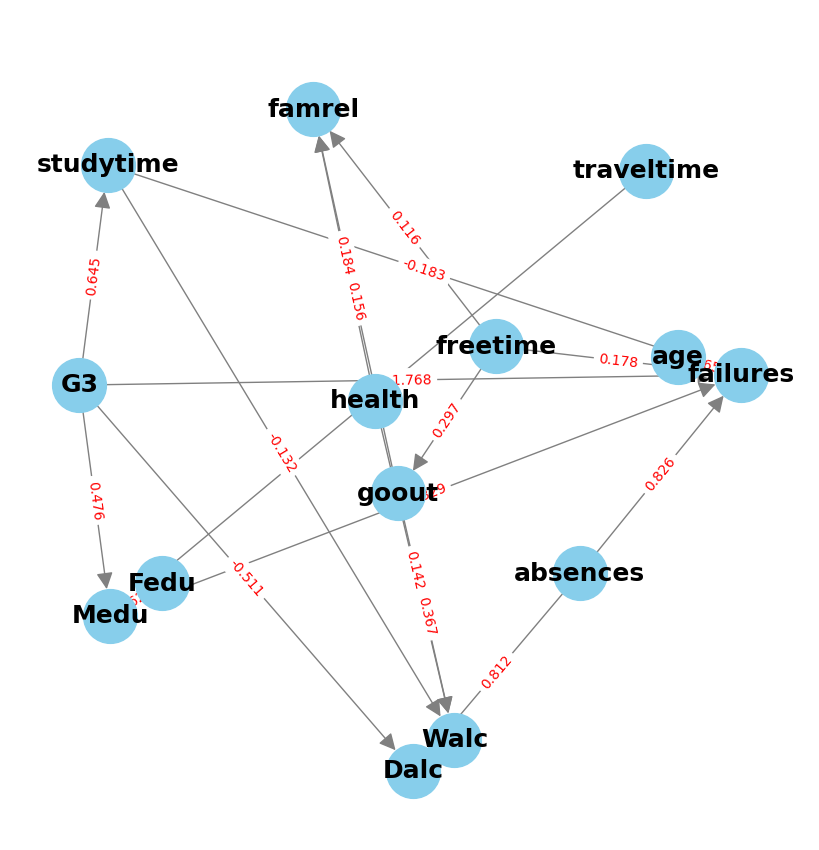

In [3]:
analyze_causal_relationships("data_OpenML_CTR23/regression/dataset_44967.csv")


📂 正在分析数据集: data_OpenML_CTR23/regression/dataset_44994.csv
🔎 特征太多，仅保留前 15 个特征用于可视化


/home/sunyvxuan/anaconda3/envs/tabpfn/lib/python3.12/site-packages/lingam/direct_lingam.py:159: RuntimeWarning: overflow encountered in cosh
  np.mean(np.log(np.cosh(u))) - gamma) ** 2 - k2 * (np.mean(u * np.exp((-(u ** 2)) / 2))) ** 2
/home/sunyvxuan/anaconda3/envs/tabpfn/lib/python3.12/site-packages/lingam/direct_lingam.py:163: RuntimeWarning: invalid value encountered in scalar subtract
  return (self._entropy(xj_std) + self._entropy(ri_j / np.std(ri_j))) - (
/home/sunyvxuan/anaconda3/envs/tabpfn/lib/python3.12/site-packages/lingam/direct_lingam.py:224: RuntimeWarning: invalid value encountered in divide
  xj_std = (X[:, j] - np.mean(X[:, j])) / np.std(X[:, j])
/home/sunyvxuan/anaconda3/envs/tabpfn/lib/python3.12/site-packages/lingam/direct_lingam.py:223: RuntimeWarning: invalid value encountered in divide
  xi_std = (X[:, i] - np.mean(X[:, i])) / np.std(X[:, i])


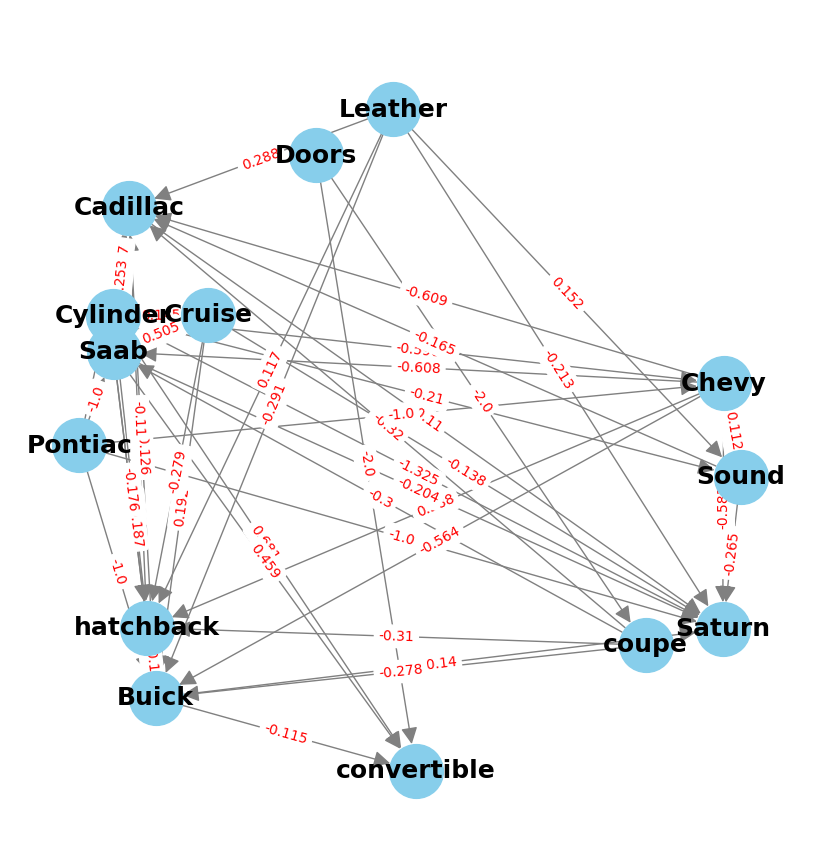

In [4]:
analyze_causal_relationships("data_OpenML_CTR23/regression/dataset_44994.csv")


📂 正在分析数据集: data_OpenML_CC18/dataset_23.csv


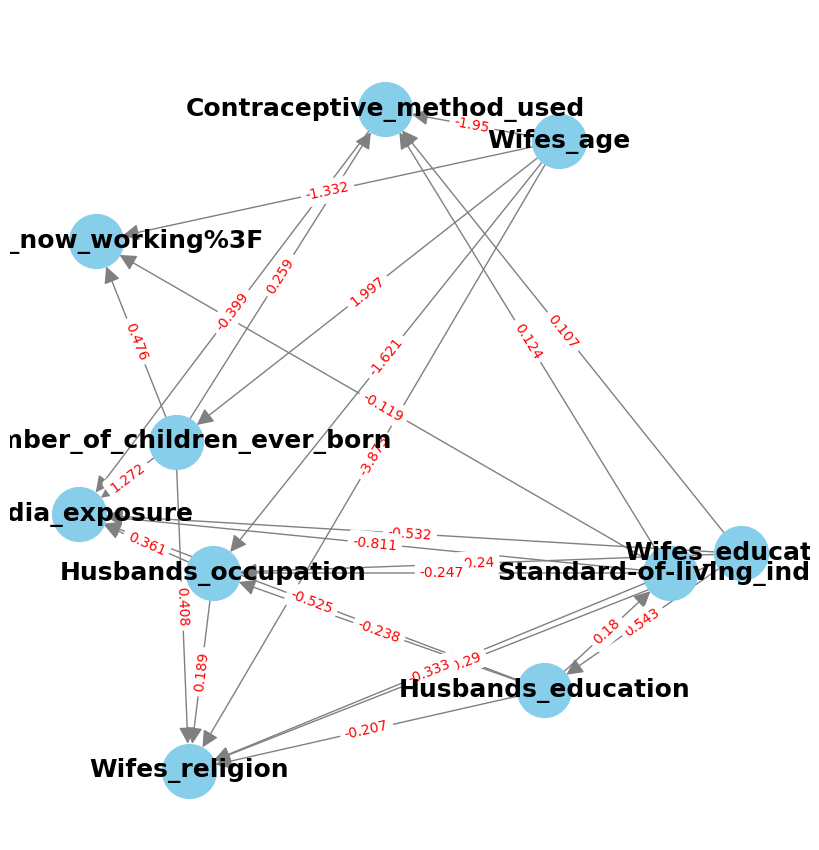

In [6]:
analyze_causal_relationships("data_OpenML_CC18/dataset_23.csv")

# Generate data

## Correlated but not Causal

In [7]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.utils import shuffle
from tabpfn import TabPFNClassifier
from scipy.stats import multivariate_normal
import time
import warnings
import gc
import torch

warnings.filterwarnings("ignore")

# 合成数据函数
def generate_data(n=5000, d=10, correlated=False, seed=42):
    np.random.seed(seed)
    # 类别均值
    mu0 = np.zeros(d)
    mu1 = np.ones(d)

    if correlated:
        # 非单位协方差矩阵：正相关
        A = np.random.rand(d, d)
        cov = np.dot(A, A.T) + np.eye(d) * 0.1
    else:
        # 单位协方差矩阵（特征独立）
        cov = np.eye(d)

    X0 = multivariate_normal(mu0, cov).rvs(size=n)
    X1 = multivariate_normal(mu1, cov).rvs(size=n)

    X = np.vstack((X0, X1))
    y = np.array([0] * n + [1] * n)

    return shuffle(X, y, random_state=seed)

# 评估函数
def evaluate_tabpfn(X, y, n_splits=5):
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    accs, aucs, times = [], [], []

    for fold, (train_idx, test_idx) in enumerate(kf.split(X, y), 1):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        clf = TabPFNClassifier(device="cuda" if torch.cuda.is_available() else "cpu",
                               n_jobs=8, ignore_pretraining_limits=True)

        start = time.time()
        clf.fit(X_train, y_train)
        end = time.time()

        y_pred = clf.predict(X_test)
        y_prob = clf.predict_proba(X_test)

        acc = accuracy_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_prob[:, 1])

        accs.append(acc)
        aucs.append(auc)
        times.append(end - start)

        del clf
        gc.collect()

    return np.mean(accs), np.std(accs), np.mean(aucs), np.std(aucs), np.mean(times)

# 主程序
for correlated in [False, True]:
    X, y = generate_data(n=1000, d=10, correlated=correlated, seed=42)
    avg_acc, std_acc, avg_auc, std_auc, avg_time = evaluate_tabpfn(X, y)

    title = "📊 特征相关" if correlated else "📊 特征独立"
    print(f"\n{title}")
    print(f"✅ Avg Accuracy: {avg_acc:.4f} ± {std_acc:.4f}")
    print(f"✅ Avg AUC:      {avg_auc:.4f} ± {std_auc:.4f}")
    print(f"⏱  Avg Time:    {avg_time:.2f} sec")


📊 特征独立
✅ Avg Accuracy: 0.9500 ± 0.0067
✅ Avg AUC:      0.9907 ± 0.0026
⏱  Avg Time:    0.47 sec

📊 特征相关
✅ Avg Accuracy: 0.6700 ± 0.0303
✅ Avg AUC:      0.7457 ± 0.0317
⏱  Avg Time:    0.41 sec


## DAG

In [2]:
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
from tabpfn import TabPFNClassifier
import gc, time, torch

# ✅ 构造不同因果结构的 DAG 图
def create_dag_structure(d=10, structure_type="chain"):
    dag = nx.DiGraph()
    dag.add_nodes_from(range(d))
    if structure_type == "chain":
        for i in range(d - 1):
            dag.add_edge(i, i + 1)
    elif structure_type == "fork":
        for i in range(1, d):
            dag.add_edge(0, i)
    elif structure_type == "collider":
        for i in range(d - 1):
            dag.add_edge(i, d - 1)
    elif structure_type == "random":
        for i in range(d):
            for j in range(i + 1, d):
                if np.random.rand() < 0.3:
                    dag.add_edge(i, j)
        dag = nx.DiGraph(nx.transitive_reduction(dag))  # 去除冗余边，保持无环
    return dag

# ✅ 根据 DAG 生成结构化数据
def generate_sem_data_from_dag(dag, n_samples=1000, seed=42):
    np.random.seed(seed)
    d = dag.number_of_nodes()
    X = np.zeros((n_samples, d))
    top_order = list(nx.topological_sort(dag))

    for node in top_order:
        parents = list(dag.predecessors(node))
        if not parents:
            X[:, node] = np.random.normal(loc=0.0, scale=1.0, size=n_samples)
        else:
            weights = np.random.uniform(0.5, 1.5, size=len(parents))
            noise = np.random.normal(0, 0.1, size=n_samples)
            X[:, node] = X[:, parents] @ weights + noise
    return X

# ✅ 构造标签（分类问题）
def generate_labels(X, informative_indices, noise_std=0.1):
    logits = X[:, informative_indices].sum(axis=1) + np.random.normal(0, noise_std, X.shape[0])
    probs = 1 / (1 + np.exp(-logits))
    return (probs > 0.5).astype(int)

# ✅ TabPFN 交叉验证评估函数
def evaluate_tabpfn(X, y, n_splits=5):
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    accs, aucs, times = [], [], []

    for fold, (train_idx, test_idx) in enumerate(kf.split(X, y), 1):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        clf = TabPFNClassifier(device="cuda" if torch.cuda.is_available() else "cpu",
                               n_jobs=40, ignore_pretraining_limits=True)
        start = time.time()
        clf.fit(X_train, y_train)
        end = time.time()

        y_pred = clf.predict(X_test)
        y_prob = clf.predict_proba(X_test)

        accs.append(accuracy_score(y_test, y_pred))
        aucs.append(roc_auc_score(y_test, y_prob[:, 1]))
        times.append(end - start)

        del clf
        gc.collect()
        torch.cuda.empty_cache()

    return np.mean(accs), np.std(accs), np.mean(aucs), np.std(aucs), np.mean(times)

# ✅ 主流程：评估不同因果结构 & 不同维度下的 TabPFN 表现
structure_types = ["independent", "chain", "fork", "collider", "random"]
dims = [5, 10, 25, 50, 100, 200, 300]
results = []

for d in dims:
    for structure in structure_types:
        print(f"🧪 正在处理结构: {structure} | 维度: {d}")
        if structure == "independent":
            np.random.seed(42)
            X0 = np.random.normal(0, 1, size=(1000, d))
            X1 = np.random.normal(1, 1, size=(1000, d))
            X = np.vstack((X0, X1))
            y = np.array([0] * 1000 + [1] * 1000)
        else:
            dag = create_dag_structure(d=d, structure_type=structure)
            X = generate_sem_data_from_dag(dag, n_samples=2000, seed=42)
            y = generate_labels(X, informative_indices=list(range(min(3, d))))

        X, y = shuffle(X, y, random_state=42)
        acc_mean, acc_std, auc_mean, auc_std, time_avg = evaluate_tabpfn(X, y)
        results.append([structure, d, acc_mean, acc_std, auc_mean, auc_std, time_avg])

results_df = pd.DataFrame(results, columns=["Structure", "Dim", "Acc", "Acc_std", "AUC", "AUC_std", "Time"])
# results_df.to_csv("tabpfn_structure_dim_results.csv", index=False)

🧪 正在处理结构: independent | 维度: 5
🧪 正在处理结构: chain | 维度: 5
🧪 正在处理结构: fork | 维度: 5
🧪 正在处理结构: collider | 维度: 5
🧪 正在处理结构: random | 维度: 5
🧪 正在处理结构: independent | 维度: 10
🧪 正在处理结构: chain | 维度: 10
🧪 正在处理结构: fork | 维度: 10
🧪 正在处理结构: collider | 维度: 10
🧪 正在处理结构: random | 维度: 10
🧪 正在处理结构: independent | 维度: 25
🧪 正在处理结构: chain | 维度: 25
🧪 正在处理结构: fork | 维度: 25
🧪 正在处理结构: collider | 维度: 25
🧪 正在处理结构: random | 维度: 25
🧪 正在处理结构: independent | 维度: 50
🧪 正在处理结构: chain | 维度: 50
🧪 正在处理结构: fork | 维度: 50
🧪 正在处理结构: collider | 维度: 50
🧪 正在处理结构: random | 维度: 50
🧪 正在处理结构: independent | 维度: 100
🧪 正在处理结构: chain | 维度: 100
🧪 正在处理结构: fork | 维度: 100
🧪 正在处理结构: collider | 维度: 100
🧪 正在处理结构: random | 维度: 100
🧪 正在处理结构: independent | 维度: 200
🧪 正在处理结构: chain | 维度: 200
🧪 正在处理结构: fork | 维度: 200
🧪 正在处理结构: collider | 维度: 200
🧪 正在处理结构: random | 维度: 200
🧪 正在处理结构: independent | 维度: 300
🧪 正在处理结构: chain | 维度: 300
🧪 正在处理结构: fork | 维度: 300
🧪 正在处理结构: collider | 维度: 300
🧪 正在处理结构: random | 维度: 300


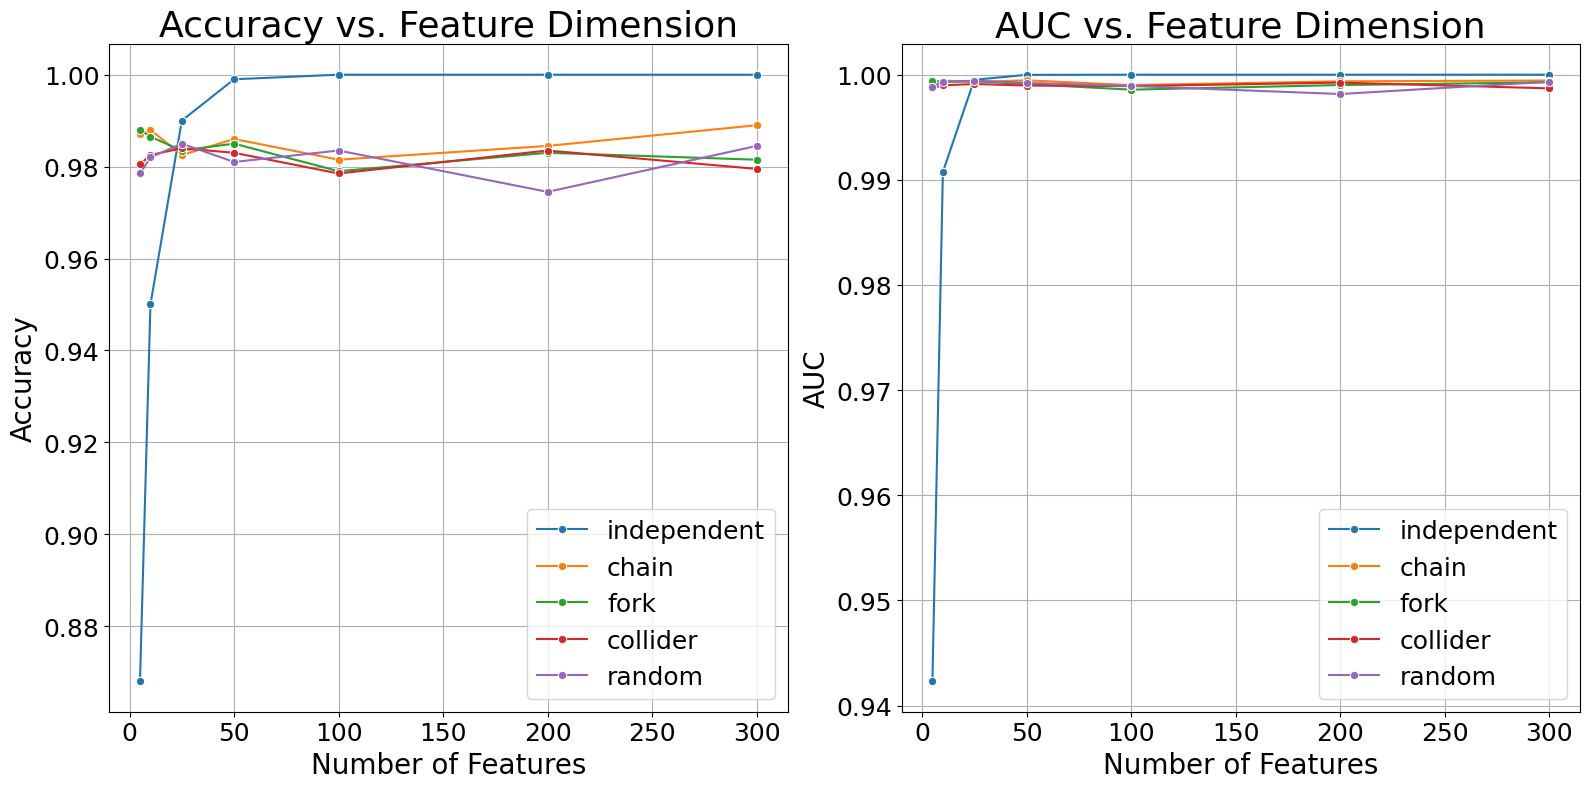

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("default")

# 加载结果
results_df.to_csv("tabpfn_structure_dim_results.csv", index=False)
df = pd.read_csv("tabpfn_structure_dim_results.csv")

plt.figure(figsize=(16, 8))
# 🎯 画 Accuracy 随维度变化
plt.subplot(1, 2, 1)
sns.lineplot(data=df, x="Dim", y="Acc", hue="Structure", marker="o")
plt.title("Accuracy vs. Feature Dimension", fontsize=26)
plt.xlabel("Number of Features", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.grid(True)
plt.tight_layout()

# 🎯 画 AUC 随维度变化
plt.subplot(1, 2, 2)
sns.lineplot(data=df, x="Dim", y="AUC", hue="Structure", marker="o")
plt.title("AUC vs. Feature Dimension", fontsize=26)
plt.xlabel("Number of Features", fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel("AUC", fontsize=20)
plt.legend(fontsize=18)
plt.grid(True)
plt.tight_layout()
plt.show()

TabPFN 在存在明确的特征间结构时表现更好，而在特征彼此完全独立的场景下，性能虽高，但略有下降。

这是符合 TabPFN 设计目标的：
- TabPFN 使用的是基于transformer 的因果推断建模方法，在预训练阶段，数据是以有结构（因果图）的形式生成的；
- 这使得模型在推理时默认假设特征间存在某种因果或条件依赖结构；
- 当数据结构和其 inductive bias 匹配时 → 模型就能表现非常出色；
- 当特征是独立的，它仍然可以很好地预测，但信息融合受限。

### Compare with other method

In [5]:
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from tabpfn import TabPFNClassifier
import gc, time, torch

# 创建因果结构
def create_dag_structure(d=10, structure_type="chain"):
    dag = nx.DiGraph()
    dag.add_nodes_from(range(d))
    if structure_type == "chain":
        for i in range(d - 1):
            dag.add_edge(i, i + 1)
    elif structure_type == "fork":
        for i in range(1, d):
            dag.add_edge(0, i)
    elif structure_type == "collider":
        for i in range(d - 1):
            dag.add_edge(i, d - 1)
    elif structure_type == "random":
        for i in range(d):
            for j in range(i + 1, d):
                if np.random.rand() < 0.3:
                    dag.add_edge(i, j)
        dag = nx.DiGraph(nx.transitive_reduction(dag))
    return dag

# 生成 SEM 数据
def generate_sem_data_from_dag(dag, n_samples=1000, seed=42):
    np.random.seed(seed)
    d = dag.number_of_nodes()
    X = np.zeros((n_samples, d))
    top_order = list(nx.topological_sort(dag))
    for node in top_order:
        parents = list(dag.predecessors(node))
        if not parents:
            X[:, node] = np.random.normal(0, 1, size=n_samples)
        else:
            weights = np.random.uniform(0.5, 1.5, size=len(parents))
            noise = np.random.normal(0, 0.1, size=n_samples)
            X[:, node] = X[:, parents] @ weights + noise
    return X

# 标签生成
def generate_labels(X, informative_indices, noise_std=0.1):
    logits = X[:, informative_indices].sum(axis=1) + np.random.normal(0, noise_std, X.shape[0])
    probs = 1 / (1 + np.exp(-logits))
    return (probs > 0.5).astype(int)

# 多模型评估函数
def evaluate_model(model, X, y, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    accs, aucs, times = [], [], []
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        start = time.time()
        model.fit(X_train, y_train)
        end = time.time()
        y_pred = model.predict(X_test)
        y_score = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
        accs.append(accuracy_score(y_test, y_pred))
        aucs.append(roc_auc_score(y_test, y_score))
        times.append(end - start)
        del X_train, X_test, y_train, y_test, y_pred, y_score
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    return np.mean(accs), np.std(accs), np.mean(aucs), np.std(aucs), np.mean(times)

# 配置
structure_types = ["independent", "causal"]
dims = [5, 10, 25, 50, 100]
models = {
    "TabPFN": lambda: TabPFNClassifier(device="cuda:1" if torch.cuda.is_available() else "cpu",
                                       n_jobs=20, ignore_pretraining_limits=True),
    "SVM": lambda: SVC(kernel="rbf", probability=True),
    "RF": lambda: RandomForestClassifier(n_estimators=100),
    # "XGBoost": lambda: XGBClassifier(n_estimators=100, eval_metric='logloss')
}

results = []

for d in dims:
    for structure in structure_types:
        # 数据生成
        if structure == "independent":
            np.random.seed(42)
            X0 = np.random.normal(0, 1, size=(1000, d))
            X1 = np.random.normal(1, 1, size=(1000, d))
            X = np.vstack((X0, X1))
            y = np.array([0] * 1000 + [1] * 1000)
        else:
            dag = create_dag_structure(d=d, structure_type="random")
            X = generate_sem_data_from_dag(dag, n_samples=2000)
            y = generate_labels(X, informative_indices=list(range(min(3, d))))

        X, y = shuffle(X, y, random_state=42)

        # 模型评估
        for model_name, model_func in models.items():
            print(f"🔍 Evaluating {model_name} | {structure} | d={d}")
            model = model_func()
            acc, acc_std, auc, auc_std, t = evaluate_model(model, X, y)
            results.append([structure, d, model_name, acc, acc_std, auc, auc_std, t])
            gc.collect()
            torch.cuda.empty_cache()

# 保存结果
df_results = pd.DataFrame(results, columns=["Type", "Dim", "Model", "Acc", "Acc_std", "AUC", "AUC_std", "Time"])
df_results.to_csv("indep_vs_causal_all_models.csv", index=False)

🔍 Evaluating TabPFN | independent | d=5


🔍 Evaluating SVM | independent | d=5
🔍 Evaluating RF | independent | d=5
🔍 Evaluating TabPFN | causal | d=5
🔍 Evaluating SVM | causal | d=5
🔍 Evaluating RF | causal | d=5
🔍 Evaluating TabPFN | independent | d=10
🔍 Evaluating SVM | independent | d=10
🔍 Evaluating RF | independent | d=10
🔍 Evaluating TabPFN | causal | d=10
🔍 Evaluating SVM | causal | d=10
🔍 Evaluating RF | causal | d=10
🔍 Evaluating TabPFN | independent | d=25
🔍 Evaluating SVM | independent | d=25
🔍 Evaluating RF | independent | d=25
🔍 Evaluating TabPFN | causal | d=25
🔍 Evaluating SVM | causal | d=25
🔍 Evaluating RF | causal | d=25
🔍 Evaluating TabPFN | independent | d=50
🔍 Evaluating SVM | independent | d=50
🔍 Evaluating RF | independent | d=50
🔍 Evaluating TabPFN | causal | d=50
🔍 Evaluating SVM | causal | d=50
🔍 Evaluating RF | causal | d=50
🔍 Evaluating TabPFN | independent | d=100
🔍 Evaluating SVM | independent | d=100
🔍 Evaluating RF | independent | d=100
🔍 Evaluating TabPFN | causal | d=100
🔍 Evaluating SVM | cau

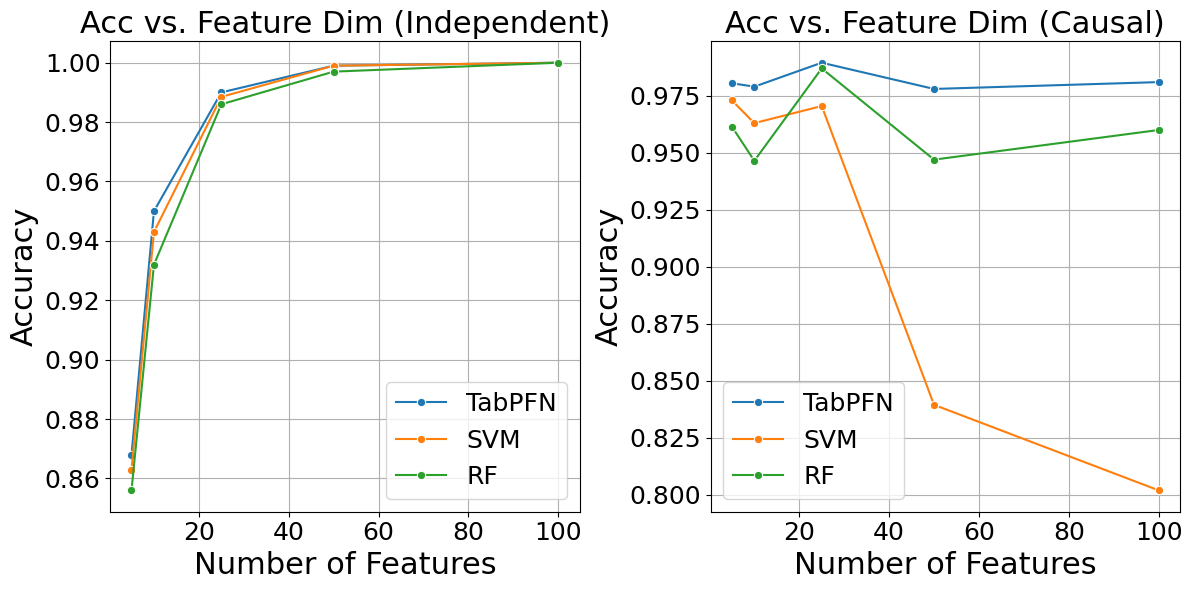

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use("default")
df = pd.read_csv("indep_vs_causal_all_models.csv")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.lineplot(data=df[df["Type"] == "independent"], x="Dim", y="Acc", hue="Model", marker="o")
plt.title("Acc vs. Feature Dim (Independent)", fontsize=22)
plt.xlabel("Number of Features", fontsize=22)
plt.ylabel("Accuracy", fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.grid(True)
plt.tight_layout()

plt.subplot(1, 2, 2)
sns.lineplot(data=df[df["Type"] == "causal"], x="Dim", y="Acc", hue="Model", marker="o")
plt.title("Acc vs. Feature Dim (Causal)", fontsize=22)
plt.xlabel("Number of Features", fontsize=22)
plt.ylabel("Accuracy", fontsize=22)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)
plt.grid(True)
plt.tight_layout()
plt.show()

## Gaussian Mix

In [14]:
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import shuffle
from tabpfn import TabPFNClassifier
from scipy.stats import multivariate_normal
import time
import gc
import warnings

warnings.filterwarnings("ignore")

def Mix_Gaussian(mu_class0, mu_class1_1, mu_class1_2, sig, n, dim_info, dim_total, mix, seed):
    np.random.seed(seed)
    pdf_class0 = multivariate_normal(mean=mu_class0, cov=sig, allow_singular=True)
    pdf_class1_1 = [multivariate_normal(mean=mu_class1_1[i], cov=sig, allow_singular=True)
                    for i in range(dim_info)]
    pdf_class1_2 = [multivariate_normal(mean=mu_class1_2[i], cov=sig, allow_singular=True)
                    for i in range(dim_info)]

    n2 = [int(n * mix_i) for mix_i in mix]
    n1 = [n - n2_i for n2_i in n2]

    x_0 = [pdf_class0.rvs(size=n)[:, i] for i in range(dim_info)]
    x_1_1 = [pdf_class1_1[i].rvs(size=n1[i])[:, i] for i in range(dim_info)]
    x_1_2 = [pdf_class1_2[i].rvs(size=n2[i])[:, i] for i in range(dim_info)]

    y = np.array([0] * n + [1] * n).reshape(-1, 1)

    X = np.zeros((2 * n, dim_info))
    for i in range(dim_info):
        X[:n, i] = x_0[i]
        X[n: n + n1[i], i] = x_1_1[i]
        X[n + n1[i]:, i] = x_1_2[i]

    X_noise = np.random.normal(0, 1, (2 * n, dim_total - dim_info))
    X_all = np.hstack((X, X_noise))

    return X_all, y.ravel()

def evaluate_tabpfn(X, y, n_splits=5):
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    accs, aucs, times = [], [], []

    for fold, (train_idx, test_idx) in enumerate(kf.split(X, y), 1):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        clf = TabPFNClassifier(device="cuda" if torch.cuda.is_available() else "cpu",
                               n_jobs=8, ignore_pretraining_limits=True)

        start = time.time()
        clf.fit(X_train, y_train)
        end = time.time()

        y_pred = clf.predict(X_test)
        y_prob = clf.predict_proba(X_test)

        accs.append(accuracy_score(y_test, y_pred))
        aucs.append(roc_auc_score(y_test, y_prob[:, 1]))
        times.append(end - start)

        del clf
        gc.collect()

    return np.mean(accs), np.std(accs), np.mean(aucs), np.std(aucs), np.mean(times)

def run_experiment():
    n = 1000
    dim_total = 300
    dims_to_test = [5, 10, 25, 50, 100, 200, 300]
    seed = 42

    for d in dims_to_test:
        print(f"\n🧪 维度: {d}")

        mix = [0.5] * d
        mu_class0 = np.zeros(d)
        mu_class1_1 = [np.ones(d) for _ in range(d)]
        mu_class1_2 = [-np.ones(d) for _ in range(d)]

        # 独立特征
        cov_indep = np.eye(d)
        X_indep, y_indep = Mix_Gaussian(mu_class0, mu_class1_1, mu_class1_2,
                                        cov_indep, n, d, dim_total, mix, seed)
        res_indep = evaluate_tabpfn(X_indep, y_indep)

        # 相关特征
        A = np.random.rand(d, d)
        cov_corr = np.dot(A, A.T) + np.eye(d) * 0.1
        X_corr, y_corr = Mix_Gaussian(mu_class0, mu_class1_1, mu_class1_2,
                                      cov_corr, n, d, dim_total, mix, seed)
        res_corr = evaluate_tabpfn(X_corr, y_corr)

        print("📊 Independent Features")
        print(f"✅ Avg Accuracy: {res_indep[0]:.4f} ± {res_indep[1]:.4f}")
        print(f"✅ Avg AUC:      {res_indep[2]:.4f} ± {res_indep[3]:.4f}")
        print(f"⏱  Avg Time:    {res_indep[4]:.2f} sec")

        print("📊 Correlated Features")
        print(f"✅ Avg Accuracy: {res_corr[0]:.4f} ± {res_corr[1]:.4f}")
        print(f"✅ Avg AUC:      {res_corr[2]:.4f} ± {res_corr[3]:.4f}")
        print(f"⏱  Avg Time:    {res_corr[4]:.2f} sec")

if __name__ == "__main__":
    run_experiment()


🧪 维度: 5


📊 Independent Features
✅ Avg Accuracy: 0.8005 ± 0.0281
✅ Avg AUC:      0.8740 ± 0.0155
⏱  Avg Time:    1.29 sec
📊 Correlated Features
✅ Avg Accuracy: 0.7355 ± 0.0237
✅ Avg AUC:      0.8039 ± 0.0093
⏱  Avg Time:    1.03 sec

🧪 维度: 10
📊 Independent Features
✅ Avg Accuracy: 0.9145 ± 0.0120
✅ Avg AUC:      0.9708 ± 0.0067
⏱  Avg Time:    1.74 sec
📊 Correlated Features
✅ Avg Accuracy: 0.6880 ± 0.0263
✅ Avg AUC:      0.7372 ± 0.0169
⏱  Avg Time:    1.39 sec

🧪 维度: 25
📊 Independent Features
✅ Avg Accuracy: 0.9865 ± 0.0046
✅ Avg AUC:      0.9989 ± 0.0005
⏱  Avg Time:    1.56 sec
📊 Correlated Features
✅ Avg Accuracy: 0.6765 ± 0.0208
✅ Avg AUC:      0.7235 ± 0.0138
⏱  Avg Time:    1.85 sec

🧪 维度: 50
📊 Independent Features
✅ Avg Accuracy: 0.9990 ± 0.0012
✅ Avg AUC:      1.0000 ± 0.0001
⏱  Avg Time:    1.06 sec
📊 Correlated Features
✅ Avg Accuracy: 0.6985 ± 0.0390
✅ Avg AUC:      0.7523 ± 0.0431
⏱  Avg Time:    1.15 sec

🧪 维度: 100
📊 Independent Features
✅ Avg Accuracy: 1.0000 ± 0.0000
✅ Avg AUC:  

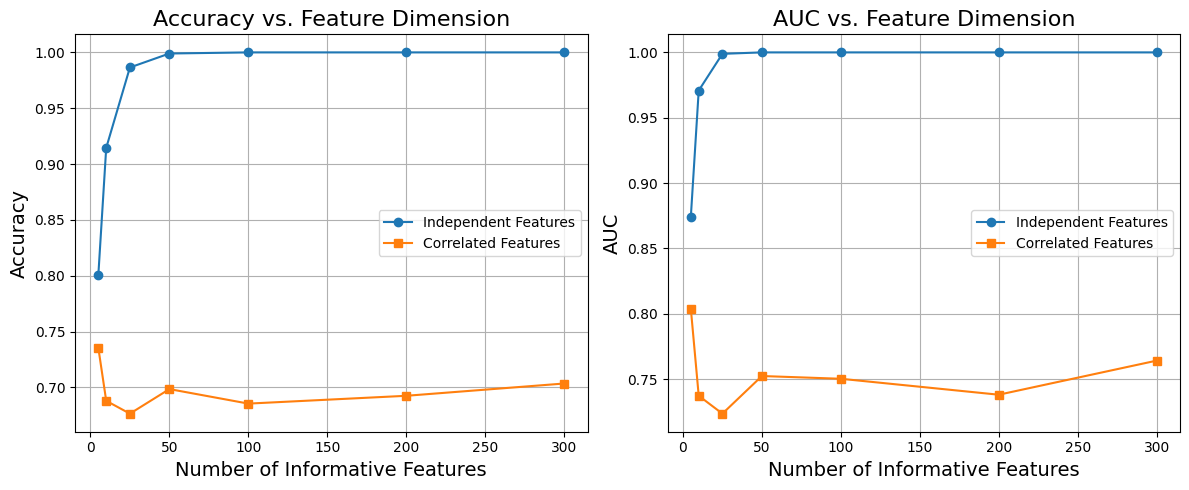

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# plot default colour white
plt.style.use("default")

# 维度
dims = [5, 10, 25, 50, 100, 200, 300]

# Accuracy
acc_indep = [0.8005, 0.9145, 0.9865, 0.9990, 1.0000, 1.0000, 1.0000]
acc_corr = [0.7355, 0.6880, 0.6765, 0.6985, 0.6855, 0.6925, 0.7035]

# AUC
auc_indep = [0.8740, 0.9708, 0.9989, 1.0000, 1.0000, 1.0000, 1.0000]
auc_corr = [0.8039, 0.7372, 0.7235, 0.7523, 0.7502, 0.7380, 0.7641]

# 绘图
plt.figure(figsize=(12, 5))

# Accuracy 曲线
plt.subplot(1, 2, 1)
plt.plot(dims, acc_indep, marker='o', label='Independent Features')
plt.plot(dims, acc_corr, marker='s', label='Correlated Features')
plt.xlabel("Number of Informative Features", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Accuracy vs. Feature Dimension", fontsize=16)
plt.legend()
plt.grid(True)

# AUC 曲线
plt.subplot(1, 2, 2)
plt.plot(dims, auc_indep, marker='o', label='Independent Features')
plt.plot(dims, auc_corr, marker='s', label='Correlated Features')
plt.xlabel("Number of Informative Features", fontsize=14)
plt.ylabel("AUC", fontsize=14)
plt.title("AUC vs. Feature Dimension", fontsize=16)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

因果结构 ≠ 相关结构（协方差）

协方差矩阵无法分辨因果的方向、传递路径、屏蔽变量等信息

想获得因果结构，需要结合结构学习算法，比如：
- LiNGAM（线性非高斯模型）
- PC / GES / NOTEARS
- 或基于注意力的神经网络（TabPFN 内部可能隐式模拟了类似结构）